In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.linalg import svd
from sklearn.metrics import root_mean_squared_error

# Step 0: Data Loading and Structural Overview

In [2]:
data = pd.read_csv('data/movielens.csv')
val_idx = pd.read_csv('data/movielens_val_indices.csv')
data_map = pd.read_pickle('data/movie_map.pkl')

In [3]:
data.head()

,userId,movieId,rating,timestamp,title,genres
0,0,0,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,0,2,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,0,4,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,0,23,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,0,25,5.0,964982931,Usual Suspects; The (1995),Crime|Mystery|Thriller


In [4]:
val_idx.head()

,row_inds,col_inds
0,541,743
1,306,387
2,153,958
3,554,649
4,253,719


In [5]:
top_5_data_map = list(data_map.items())[:5]
top_5_data_map

[(0, 'Toy Story (1995)'),
 (2, 'Grumpier Old Men (1995)'),
 (4, 'Heat (1995)'),
 (23, 'Seven (a.k.a. Se7en) (1995)'),
 (25, 'Usual Suspects; The (1995)')]

In [6]:
data_results = []
data_results.append({'Data':'movielens size', 'Value':data.shape})
data_results.append({'Data':'movielens columns', 'Value':data.columns})
data_results.append({'Data':'movielens_val_indices size', 'Value':val_idx.shape})
data_results.append({'Data':'movielens_val_indices columns', 'Value':val_idx.columns})
data_results.append({'Data':'data_map size', 'Value':len(data_map)})
data_results.append({'Data':'data_map type', 'Value':type(data_map)})

data_results = pd.DataFrame(data_results)
data_results

,Data,Value
0,movielens size,"(62518, 6)"
1,movielens columns,"Index(['userId', 'movieId', 'rating', 'timesta..."
2,movielens_val_indices size,"(6252, 2)"
3,movielens_val_indices columns,"Index(['row_inds', 'col_inds'], dtype='object')"
4,data_map size,1050
5,data_map type,<class 'dict'>


# Step 1: Construct the Rating Matrix and Validation Split

## Build rating matrix A

In [7]:
num_users = data["userId"].nunique()
num_movies = len(data_map)

initial_data = data[['userId', 'movieId', 'rating']]

A = np.zeros((num_users, num_movies))
for _, row in initial_data.iterrows():
    A[int(row["userId"]), int(row["movieId"])] = row["rating"]

In [8]:
print("A shape:", A.shape)
print("A nonzeros:", np.count_nonzero(A))
print("A sum:", A.sum())

A shape: (610, 1050)
A nonzeros: 62518
A sum: 227818.5


In [9]:
A[:5]

array([[4., 0., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.]])

## Validation split

In [10]:
rows = val_idx["row_inds"].values
cols = val_idx["col_inds"].values

A_fit = A.copy()
y_val_true = A[rows, cols]
A_fit[rows, cols] = 0

In [11]:
print("All validation entries zeroed:",
      np.all(A_fit[rows, cols] == 0))

print("A_fit sum:", A_fit.sum())

print("y_val_true (first 5 samples):", y_val_true[:5])
print("y_val_true (last 5 samples):", y_val_true[-5:])

All validation entries zeroed: True
A_fit sum: 205049.0
y_val_true (first 5 samples): [4.  2.  5.  3.  4.5]
y_val_true (last 5 samples): [4. 3. 3. 3. 4.]


# Step 2: Data Imputation

## fill-zero

In [12]:
A_fit_zero = A_fit

## fill-mean

In [13]:
global_mean = A_fit[A_fit != 0].mean()
A_fit_mean = A_fit.copy()

num_users, num_movies = A_fit_mean.shape
for u_idx in range(num_users):
    user_ratings = A_fit_mean[u_idx, :]
    nonzero_mask = (user_ratings != 0)

    if np.any(nonzero_mask):
        user_mean = user_ratings[nonzero_mask].mean()
    else:
        user_mean = global_mean

    A_fit_mean[u_idx, ~nonzero_mask] = user_mean


print("A_fit_mean shape:", A_fit_mean.shape)
print("A_fit_mean nonzeros:", np.count_nonzero(A_fit_mean))
print("A_fit_mean sum:", A_fit_mean.sum())
print('Global Mean:', global_mean)

A_fit_mean shape: (610, 1050)
A_fit_mean nonzeros: 640500
A_fit_mean sum: 2384086.2986536995
Global Mean: 3.6442789606511927


In [14]:
A_fit_mean[:5]

array([[4.        , 4.4       , 4.        , ..., 4.4       , 4.4       ,
        4.4       ],
       [3.90909091, 3.90909091, 3.90909091, ..., 3.90909091, 3.90909091,
        3.90909091],
       [1.73684211, 1.73684211, 1.73684211, ..., 1.73684211, 1.73684211,
        1.73684211],
       [3.55263158, 3.55263158, 3.55263158, ..., 3.55263158, 3.55263158,
        3.55263158],
       [4.        , 3.56756757, 3.56756757, ..., 3.56756757, 3.56756757,
        3.56756757]])

# Step 3: SVD Reconstruction and Validation RMSE

## 3.1: SVD Reconstruction with Fill-zero

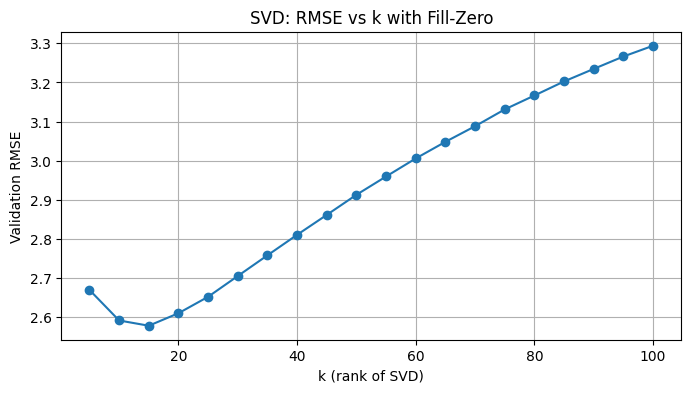

In [15]:
val_rows = val_idx["row_inds"].values
val_cols = val_idx["col_inds"].values

U, s, VT = svd(A_fit_zero, full_matrices=False)
k_values = list(range(5, 101, 5))

svd_fill_zero = []
for k in k_values:
    Uk = U[:, :k]
    Sk = np.diag(s[:k])
    Vk = VT[:k, :]

    A_hat = Uk @ Sk @ Vk

    pred = A_hat[val_rows, val_cols]
    true = A[val_rows, val_cols]
    rmse = root_mean_squared_error(true, pred)
    svd_fill_zero.append(rmse)


plt.figure(figsize=(8, 4))
plt.plot(k_values, svd_fill_zero, marker='o', label='A_fit zeros')

plt.xlabel("k (rank of SVD)")
plt.ylabel("Validation RMSE")
plt.title("SVD: RMSE vs k with Fill-Zero")
plt.grid(True)
plt.show()

## 3.2: SVD Reconstruction with Fill-Mean

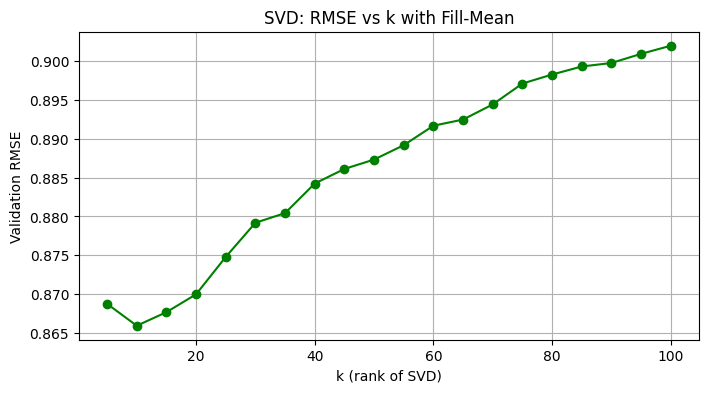

In [16]:
U, s, VT = svd(A_fit_mean, full_matrices=False)
k_values = list(range(5, 101, 5))

svd_fill_mean = []
for k in k_values:
    Uk = U[:, :k]
    Sk = np.diag(s[:k])
    Vk = VT[:k, :]

    A_hat = Uk @ Sk @ Vk

    pred = A_hat[val_rows, val_cols]
    true = A[val_rows, val_cols]
    rmse = root_mean_squared_error(true, pred)
    svd_fill_mean.append(rmse)


plt.figure(figsize=(8, 4))
plt.plot(k_values, svd_fill_mean, marker='o', color='green', label='A_fit Mean')

plt.xlabel("k (rank of SVD)")
plt.ylabel("Validation RMSE")
plt.title("SVD: RMSE vs k with Fill-Mean")
plt.grid(True)
plt.show()

## 3.3: SVD-Mean-Fill Vs SVD-Zero-Fill

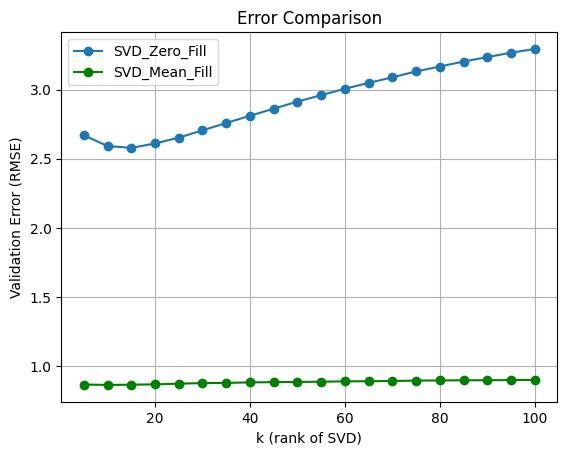

In [17]:
plt.plot(k_values, svd_fill_zero, label="SVD_Zero_Fill", marker='o')
plt.plot(k_values, svd_fill_mean, label="SVD_Mean_Fill", marker='o', color='green')

plt.xlabel("k (rank of SVD)")
plt.ylabel("Validation Error (RMSE)")
plt.title("Error Comparison")
plt.legend()
plt.grid(True)

plt.show()

# Step 4: PCA Implementation and Comparison

## 4.1: PCA with Fill-Zero (Covariance Matrix & SVD)

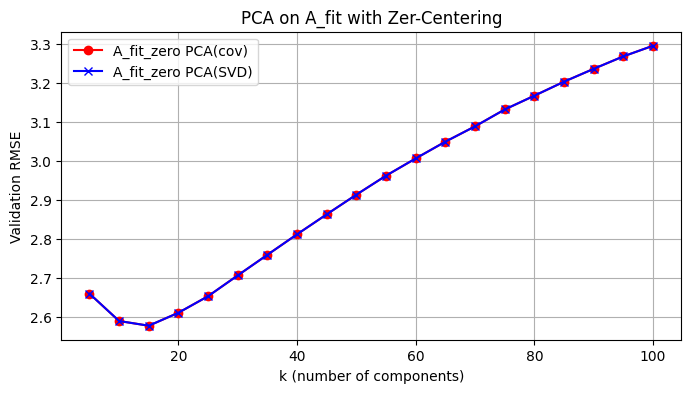

In [26]:
val_rows = val_idx["row_inds"].values
val_cols = val_idx["col_inds"].values

k_values = list(range(5, 101, 5))

# center by column
col_mean = A_fit_zero.mean(axis=0)
A_zero_centered = A_fit_zero - col_mean

# PCA via Covariance
cov_mat = np.cov(A_zero_centered, rowvar=False)
eigvals, eigvecs = np.linalg.eigh(cov_mat)
idx = np.argsort(eigvals)[::-1]
eigvecs = eigvecs[:, idx]

pca_cov_zero = []
for k in k_values:
    V_k = eigvecs[:, :k]
    A_pred = (A_zero_centered @ V_k @ V_k.T) + col_mean

    pred = A_pred[val_rows, val_cols]
    true = A[val_rows, val_cols]
    rmse = root_mean_squared_error(true, pred)
    pca_cov_zero.append(rmse)


# PCA via SVD
col_mean = A_fit_zero.mean(axis=0)
A_zero_centered = A_fit_zero - col_mean
U, s, VT = np.linalg.svd(A_zero_centered, full_matrices=False)

pca_svd_zero = []
for k in k_values:
    Uk = U[:, :k]
    Sk = np.diag(s[:k])
    Vk = VT[:k, :]
    A_pred = (Uk @ Sk @ Vk) + col_mean

    pred = A_pred[val_rows, val_cols]
    true = A[val_rows, val_cols]
    rmse = root_mean_squared_error(true, pred)
    pca_svd_zero.append(rmse)


plt.figure(figsize=(8,4))
plt.plot(k_values, pca_cov_zero, marker='o', color='red', label='A_fit_zero PCA(cov)')
plt.plot(k_values, pca_svd_zero, marker='x', color='blue', label='A_fit_zero PCA(SVD)')
plt.xlabel("k (number of components)")
plt.ylabel("Validation RMSE")
plt.title("PCA on A_fit with Zer-Centering")
plt.legend()
plt.grid(True)
plt.show()

## 4.2: PCA with Fill-Mean (Covariance Matrix & SVD)

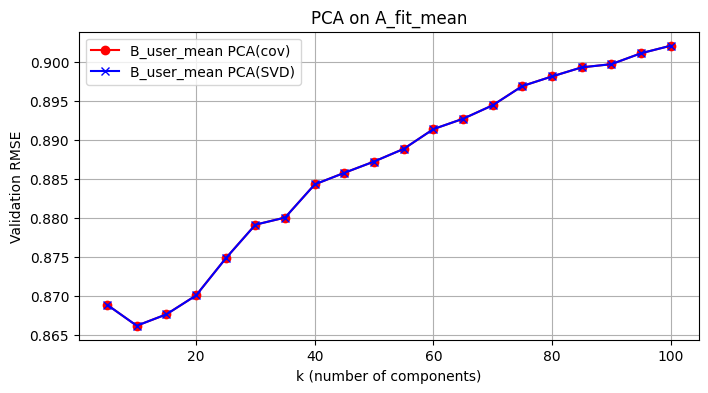

In [25]:
# PCA via Covariance
col_mean = A_fit_mean.mean(axis=0)
M_centered = A_fit_mean - col_mean

cov_mat = np.cov(M_centered, rowvar=False)
eigvals, eigvecs = np.linalg.eigh(cov_mat)
idx = np.argsort(eigvals)[::-1]
eigvecs = eigvecs[:, idx]

pca_cov_mean = []
for k in k_values:
    V_k = eigvecs[:, :k]
    M_hat = (M_centered @ V_k @ V_k.T) + col_mean

    pred = M_hat[val_rows, val_cols]
    true = A[val_rows, val_cols]
    rmse = root_mean_squared_error(true, pred)
    pca_cov_mean.append(rmse)


# PCA via SVD
col_mean = A_fit_mean.mean(axis=0)
M_centered = A_fit_mean - col_mean
U, s, VT = np.linalg.svd(M_centered, full_matrices=False)

pca_svd_mean = []
for k in k_values:
    Uk = U[:, :k]
    Sk = np.diag(s[:k])
    Vk = VT[:k, :]
    M_hat = (Uk @ Sk @ Vk) + col_mean

    pred = M_hat[val_rows, val_cols]
    true = A[val_rows, val_cols]
    rmse = root_mean_squared_error(true, pred)
    pca_svd_mean.append(rmse)

plt.figure(figsize=(8, 4))
plt.plot(k_values, pca_cov_mean, marker='o', color='red', label='B_user_mean PCA(cov)')
plt.plot(k_values, pca_svd_mean, marker='x', color='blue', label='B_user_mean PCA(SVD)')
plt.xlabel("k (number of components)")
plt.ylabel("Validation RMSE")
plt.title("PCA on A_fit_mean")
plt.legend()
plt.grid(True)
plt.show()

## 4.3: PCA-Zero-Fill Vs PCA-Mean-Fill

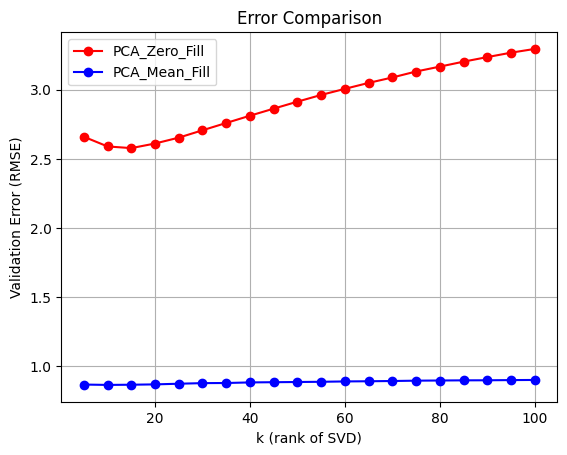

In [20]:
plt.plot(k_values, pca_svd_zero, label="PCA_Zero_Fill", marker='o', color='red')
plt.plot(k_values, pca_svd_mean, label="PCA_Mean_Fill", marker='o', color='blue')

plt.xlabel("k (rank of SVD)")
plt.ylabel("Validation Error (RMSE)")
plt.title("Error Comparison")
plt.legend()
plt.grid(True)

plt.show()

# Step 5: Find best k and RMSE for each method

In [21]:
k_values = list(range(5, 101, 5))
result = []

# the best k for SVD with zero filling
idx = np.argmin(svd_fill_zero)
best_svd_zero_k = k_values[idx]
best_svd_zero_rmse = svd_fill_zero[idx]
result.append({'method': 'SVD + fill(0)', 'Best_k': best_svd_zero_k, 'Best_RMSE': best_svd_zero_rmse})

# the best k for SVD with mean filling
idx = np.argmin(svd_fill_mean)
best_svd_mean_k = k_values[idx]
best_svd_mean_rmse = svd_fill_mean[idx]
result.append({'method': 'SVD + fill(mean)', 'Best_k': best_svd_mean_k, 'Best_RMSE': best_svd_mean_rmse})

# the best k for PCA (Cov mode) with zero filling
idx = np.argmin(pca_cov_zero)
best_pca_zero_k = k_values[idx]
best_pca_zero_rmse = pca_cov_zero[idx]
result.append({'method': 'PCA(cov) + fill(0)', 'Best_k': best_pca_zero_k, 'Best_RMSE': best_pca_zero_rmse})

# the best k for PCA (Cov mode) with mean filling
idx = np.argmin(pca_cov_mean)
best_pca_mean_k = k_values[idx]
best_pca_mean_rmse = pca_cov_mean[idx]
result.append({'method': 'PCA(cov) + fill(mean)', 'Best_k': best_pca_mean_k, 'Best_RMSE': best_pca_mean_rmse})


# the best k for PCA (SVD mode) with zero filling
idx = np.argmin(pca_svd_zero)
best_pca_svd_zero_k = k_values[idx]
best_pca_svd_zero_rmse = pca_svd_zero[idx]
result.append({'method': 'PCA(svd) + fill(zero)', 'Best_k': best_pca_svd_zero_k, 'Best_RMSE': best_pca_svd_zero_rmse})


# the best k for PCA (SVD mode) with mean filling
idx = np.argmin(pca_svd_mean)
best_pca_svd_mean_k = k_values[idx]
best_pca_svd_mean_rmse = pca_svd_mean[idx]
result.append({'method': 'PCA(svd) + fill(mean)', 'Best_k': best_pca_svd_mean_k, 'Best_RMSE': best_pca_svd_mean_rmse})

result = pd.DataFrame(result)
result

,method,Best_k,Best_RMSE
0,SVD + fill(0),15,2.578572
1,SVD + fill(mean),10,0.865916
2,PCA(cov) + fill(0),15,2.578147
3,PCA(cov) + fill(mean),10,0.866142
4,PCA(svd) + fill(zero),15,2.578147
5,PCA(svd) + fill(mean),10,0.866142


# Step 6: User Analysis And Recommendation

## 6.1: Select the user with the most validation samples

In [22]:
val_rows = val_idx["row_inds"].values
val_cols = val_idx["col_inds"].values

val_counts = pd.Series(val_rows).value_counts()

user_id = val_counts.idxmax()
user_val_count = val_counts.max()

print("Selected user:", user_id)
print(f"Validation count for user {user_id}:", user_val_count)

Selected user: 413
Validation count for user 413: 93


## 6.2: Predict ratings for unseen movies (Top-10 recommendation)

In [23]:
# The best Approach
U, s, VT = svd(A_fit_mean, full_matrices=False)

k = 10
Uk, sk, Vk = U[:, :k], np.diag(s[:k]), VT[:k, :]
best_A_hat = Uk @ sk @ Vk

In [24]:
unseen_movies = np.where(A[user_id] == 0)[0]
pred_scores = best_A_hat[user_id, unseen_movies]

# Recommendation table
top10_idx = np.argsort(pred_scores)[-10:][::-1]

top10_movies = unseen_movies[top10_idx]
top10_scores = pred_scores[top10_idx]

top10_df = pd.DataFrame({"movieId": top10_movies, "predicted_rating": top10_scores})
top10_df["title"] = top10_df["movieId"].map(data_map)
top10_df

,movieId,predicted_rating,title
0,256,4.209631,English Patient; The (1996)
1,286,4.197935,Manhattan (1979)
2,868,4.178226,Corpse Bride (2005)
3,321,4.173752,Birds; The (1963)
4,294,4.162800,Shining; The (1980)
5,457,4.156792,Strangers on a Train (1951)
6,302,4.143391,Arsenic and Old Lace (1944)
7,280,4.141230,Annie Hall (1977)
8,209,4.089251,My Fair Lady (1964)
9,312,4.070009,Ben-Hur (1959)
